<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Analyze-a-DD-SIMCA-Model" data-toc-modified-id="Analyze-a-DD-SIMCA-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyze a DD-SIMCA Model</a></span><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#A-Simple-Model" data-toc-modified-id="A-Simple-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>A Simple Model</a></span></li><li><span><a href="#An-Optimized-Pipeline" data-toc-modified-id="An-Optimized-Pipeline-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>An Optimized Pipeline</a></span></li><li><span><a href="#Create-an-Explainer" data-toc-modified-id="Create-an-Explainer-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Create an Explainer</a></span></li><li><span><a href="#A-Manual-Improvement" data-toc-modified-id="A-Manual-Improvement-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>A Manual Improvement</a></span></li></ul></li><li><span><a href="#Analyze-an-EllipticManifold-Model" data-toc-modified-id="Analyze-an-EllipticManifold-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyze an EllipticManifold Model</a></span></li><li><span><a href="#Analyze-a-PLS-DA-Model" data-toc-modified-id="Analyze-a-PLS-DA-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze a PLS-DA Model</a></span><ul class="toc-item"><li><span><a href="#Examine-Categories" data-toc-modified-id="Examine-Categories-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Examine Categories</a></span></li><li><span><a href="#How-are-decisions-made?" data-toc-modified-id="How-are-decisions-made?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>How are decisions made?</a></span></li></ul></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git
    !cd pychemauth; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../')

import pychemauth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

import shap
shap.initjs()

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [3]:
import bokeh
from bokeh.plotting import output_notebook
from pychemauth.utils import bokeh_color_spectrum
from pychemauth.utils import color_spectrum
output_notebook()

Loading BokehJS ...

Overview
-------------
This notebook demonstrates the use of SHAP to explain model predictions.

For "soft" models / OCC, we need to look at the likelihood a sample is assigned as an inlier or not; when models combine many of these (e.g., PLS-DA) we need to pull those apart to inspect each known class.  Typically, a model may be trained and TEFF optimized.  From this, optimal hyperparameters can be extracted then individual models retrained and examined to explain predictions. 

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

watermark : 2.3.1
sys       : 3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]
sklearn   : 1.0.2
bokeh     : 2.4.3
matplotlib: 3.4.3
imblearn  : 0.9.0
numpy     : 1.21.6
pychemauth: 0.0.0
shap      : 0.41.0
pandas    : 1.3.5



# Analyze a DD-SIMCA Model

## Load the Data

In [5]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/simca_train.csv'
else:
    loc = '../tests/data/simca_train.csv'
df = pd.read_csv(loc)

In [6]:
# You can see that samples are rows, columns are different features
df.head()

,Group,Class,Name,3999,3991,3983,3975,3967,3959,3951,...,527,519,511,503,495,487,479,471,463,455
0,1,Pure,F 16 08 001 D,-0.968873,-0.969487,-0.970409,-0.969794,-0.970101,-0.971944,-0.970409,...,2.629155,2.652808,2.665095,2.684140,2.700114,2.693664,2.721617,2.728067,2.718238,2.668986
1,1,Pure,F 16 08 002 D,-0.965464,-0.964848,-0.965464,-0.966697,-0.966389,-0.968238,-0.968546,...,2.669310,2.672083,2.703205,2.711524,2.749117,2.733402,2.765756,2.758977,2.775000,2.714092
2,1,Pure,F 16 08 003 D,-0.968031,-0.969617,-0.968665,-0.970568,-0.970568,-0.970568,-0.971203,...,2.538191,2.525503,2.544218,2.570861,2.570544,2.567690,2.566421,2.566739,2.547390,2.592536
3,1,Pure,F 16 08 005 D,-0.957622,-0.957622,-0.958654,-0.958654,-0.960374,-0.959686,-0.957622,...,2.626278,2.622494,2.646919,2.666528,2.685448,2.685792,2.708497,2.693705,2.689920,2.707809
4,1,Pure,F 16 08 006 D,-0.960211,-0.961166,-0.961166,-0.961803,-0.961803,-0.962758,-0.963713,...,2.698431,2.711802,2.710846,2.746185,2.777385,2.767516,2.800307,2.807311,2.764331,2.773564


In [7]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

X_train = raw_x

In [8]:
from pychemauth.classifier.simca import DDSIMCA_Model
from pychemauth.preprocessing.scaling import CorrectedScaler
from pychemauth.preprocessing.filter import SavGol

## A Simple Model

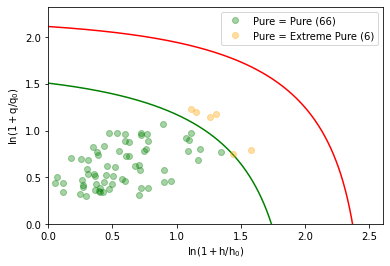

In [9]:
# Here the data is spectra so we will not scale the X data
model = DDSIMCA_Model(n_components=7, alpha=0.05, gamma=0.01, scale_x=False)
_ = model.fit(X_train, raw_y)
_ = model.visualize(X_train, raw_y)

In [10]:
mask1 = model.predict_proba(X_train)[:,0] > 0.5
mask2 = model.predict(X_train)
np.all(mask1 == mask2)

True

In [11]:
model.predict(X_train)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True])

In [12]:
model.accuracy(X_train, np.array([True]*len(X_train)))

0.9166666666666666

In [13]:
model.score(X_train, np.array([True]*len(X_train))) # Negative log loss

0.30950307683149464

## An Optimized Pipeline

In [14]:
import imblearn

# Let's use some Pareto scaling just as an illustration, even though this may not be ideal with spectral data
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", 
     CorrectedScaler(
        with_mean=True, 
        with_std=True, 
        pareto=True, 
        biased=False
     )
    ),
    ("savgol",
     SavGol(
         window_length=11, 
         deriv=2, 
         polyorder=3
     )
    ),
    ("simca", 
     DDSIMCA_Model(
         n_components=7, 
         alpha=0.05, 
         scale_x=False
     )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'scaling__pareto': [True, False],
    'scaling__with_std': [True, False],
    'savgol__window_length': [5, 13],
    'savgol__deriv': [0, 1, 2],
    'savgol__polyorder': [3],
    'simca__n_components': np.arange(1, 10, 2),
}]

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True,
)

_ = model.fit(
    X_train, 
    np.array([True]*len(X_train))
)

In [15]:
model.best_params_ 

{'savgol__deriv': 2,
 'savgol__polyorder': 3,
 'savgol__window_length': 5,
 'scaling__pareto': True,
 'scaling__with_std': True,
 'simca__n_components': 9}

In [16]:
# model.cv_results_ # View full CV results

In [17]:
# Look for any ties - in this case, not substantially different
np.array(model.cv_results_['params'])[model.cv_results_['rank_test_score'] == 1]

array([{'savgol__deriv': 2, 'savgol__polyorder': 3, 'savgol__window_length': 5, 'scaling__pareto': True, 'scaling__with_std': True, 'simca__n_components': 9}],
      dtype=object)

In [18]:
model.predict_proba(X_train)[:10]

array([[0.80157174, 0.19842826],
       [0.77876142, 0.22123858],
       [0.58113483, 0.41886517],
       [0.76897459, 0.23102541],
       [0.73446243, 0.26553757],
       [0.85017725, 0.14982275],
       [0.63524595, 0.36475405],
       [0.81969571, 0.18030429],
       [0.7838416 , 0.2161584 ],
       [0.83270826, 0.16729174]])

## Create an Explainer

In [19]:
# If you have a small dataset with only a few features you can use the entire training dataset for 
# the background (data). In problems with more features you probably want to pass only the median 
# of the training dataset, or weighted k-medians.
# See https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html
# Since we have some spectral data with > 400 features, we can just use a random subsample of 10 as 
# the background.

# See SHAP documentation for a discussion on the utility and impact of using a "squashing function" to 
# go from an unbounded "margin space" (raw model output) to a bounded probability space.
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html#Probability-space-explaination
explainer = shap.KernelExplainer(
    model = model.predict_proba, # Use probability function to "squash"
    data = shap.sample(X_train, 10, random_state=0), # vs. data = X_train to use full training set
    seed = 42
)

In [20]:
# If there are many features to explain, this can fail to converge. You can choose to look at just
# the top features as shown below.  Feature correlation can also be a concern.  Using a smaller subset
# of decorrelated inputs.

# Consider BorutaShap, Heirarchical clustering, etc.

shap_values = explainer.shap_values(X_train, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    ),
                                    gc_collect = True
                                   )

  0%|          | 0/72 [00:00<?, ?it/s]

In [21]:
explainer.expected_value 

array([0.70303459, 0.29696541])

In [22]:
np.mean(model.predict_proba(X_train)[:,0]) 
# If the background sampling was bad, the mean model prediction will differ greatly from the 
# explainer.expected_value. If this is large, consider increasing the number of background samples.

0.7478230555030897

In [23]:
shap.force_plot(
    base_value=explainer.expected_value[0], # [0] to look at inlier probability
    shap_values=shap_values[0], # [0] to look at inlier probability
    features=X_train, # Feature values for visualization
    feature_names=['Channel {}'.format(i) for i in range(X_train.shape[1])] # Feature names for visualization
)

In [24]:
# Look at the lowest probability example
look_at = np.argmin(model.predict_proba(X_train)[:,0]) 

shap.force_plot(
    base_value=explainer.expected_value[0], # [0] to look at inlier probability
    shap_values=shap_values[0][look_at,:], # [0] to look at inlier probability
    features=raw_x[look_at,:], # Feature values for visualization
    feature_names=['Channel {}'.format(i) for i in range(X_train.shape[1])] # Feature names for visualization
)

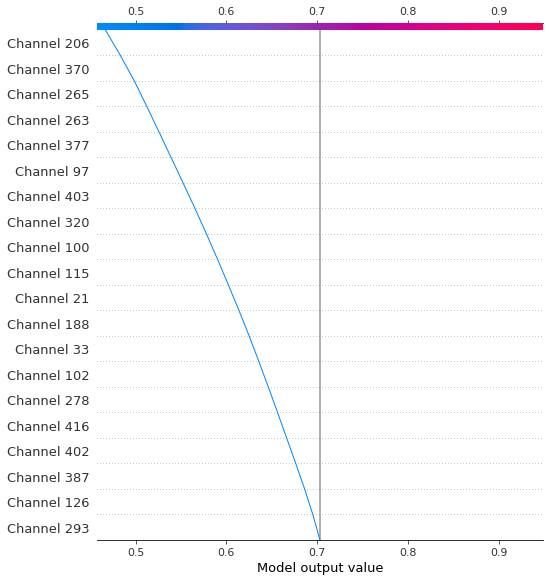

In [25]:
shap.decision_plot(
    explainer.expected_value[0], 
    shap_values[0][look_at,:],
    feature_names=['Channel {}'.format(i) for i in range(raw_x.shape[1])]
)

Text(0.5, 1.0, 'Worst Example')

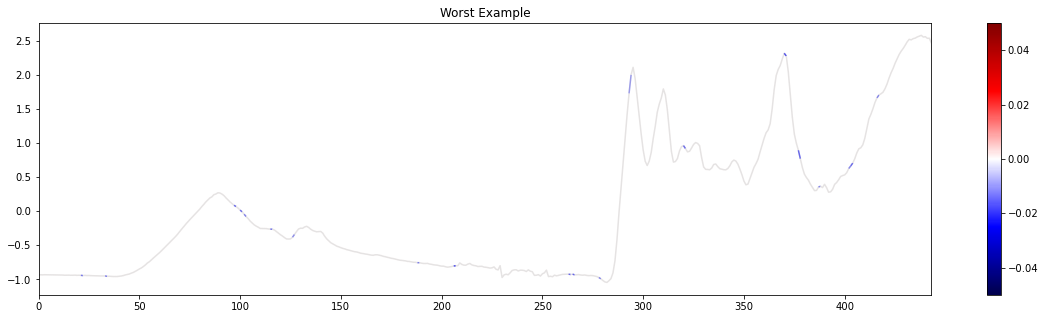

In [26]:
ax = color_spectrum(
    y=X_train[look_at,:], 
    x=np.arange(X_train.shape[1]),
    importance_values=shap_values[0][look_at], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Worst Example')

Text(0.5, 1.0, 'Best Example')

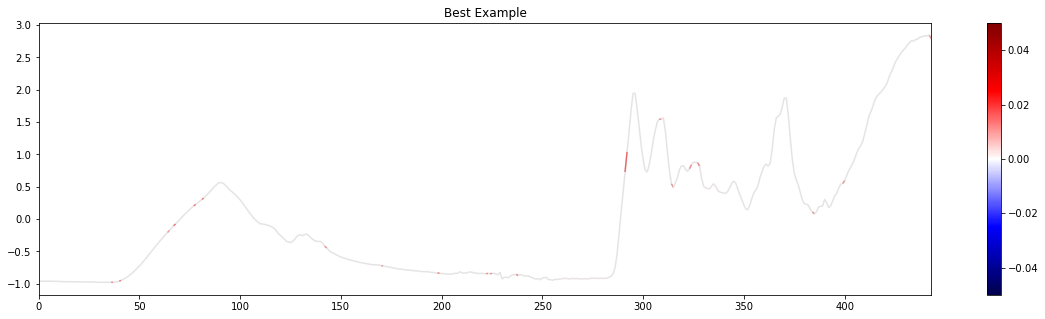

In [27]:
best = np.argmax(model.predict_proba(X_train)[:,0])
ax = color_spectrum(
    y=X_train[best,:], 
    x=np.arange(X_train.shape[1]),
    importance_values=shap_values[0][best], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Best Example')

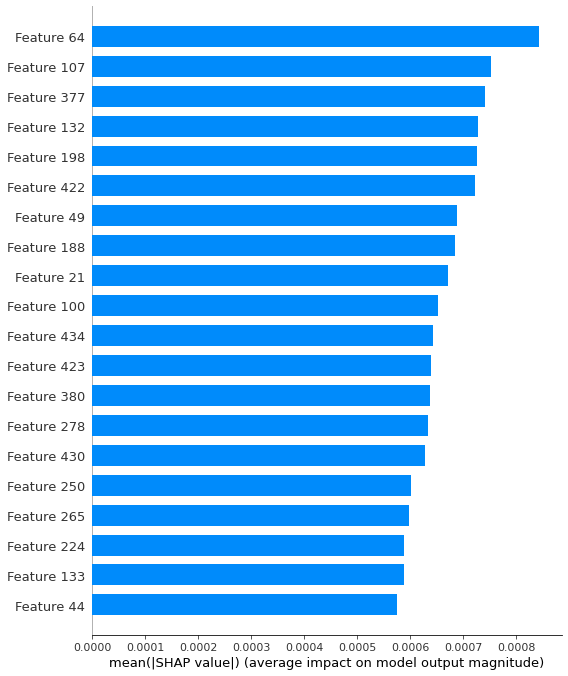

In [28]:
shap.summary_plot(
    shap_values=shap_values[0],
    features=X_train,
    plot_type='bar'
)

## A Manual Improvement

In [29]:
# Let's just choose to trim off the initial part of the spectrum
X_refined = X_train[:, 50:]

In [30]:
import imblearn

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", 
     CorrectedScaler(
        with_mean=True, 
        with_std=True, 
        pareto=True, 
        biased=False
     )
    ),
    ("savgol",
     SavGol(
         window_length=11, 
         deriv=2, 
         polyorder=3
     )
    ),
    ("simca", 
     DDSIMCA_Model(
         n_components=7, 
         alpha=0.05, 
         scale_x=False
     )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'scaling__pareto': [True, False],
    'scaling__with_std': [True, False],
    'savgol__window_length': [5, 13],
    'savgol__deriv': [0, 1, 2],
    'savgol__polyorder': [3],
    'simca__n_components': np.arange(1, 10, 2),
}]

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True,
)

_ = model.fit(
    X_refined, 
    np.array([True]*len(X_refined))
)

In [31]:
# Look for any ties - in this case, not substantially different
np.array(model.cv_results_['params'])[model.cv_results_['rank_test_score'] == 1]

array([{'savgol__deriv': 1, 'savgol__polyorder': 3, 'savgol__window_length': 5, 'scaling__pareto': False, 'scaling__with_std': True, 'simca__n_components': 9}],
      dtype=object)

In [32]:
model.best_params_

{'savgol__deriv': 1,
 'savgol__polyorder': 3,
 'savgol__window_length': 5,
 'scaling__pareto': False,
 'scaling__with_std': True,
 'simca__n_components': 9}

In [33]:
explainer = shap.KernelExplainer(
    model = model.predict_proba, # Use probability function to "squash"
    data = shap.sample(X_refined, 10, random_state=0), 
    seed = 42
)

In [34]:
explainer.expected_value

array([0.70277049, 0.29722951])

In [35]:
np.mean(model.predict_proba(X_refined)[:,0]) 

0.7477664459081057

In [36]:
shap_values = explainer.shap_values(X_refined, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_refined.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    ),
                                    gc_collect = True
                                   )

  0%|          | 0/72 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Worst Example')

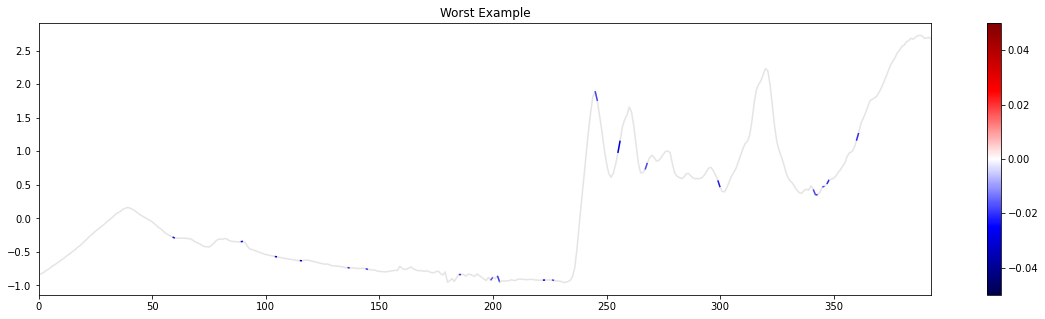

In [37]:
worst = np.argmin(model.predict_proba(X_refined)[:,0])

ax = color_spectrum(
    x=np.arange(X_refined.shape[1]),
    y=X_refined[worst,:], 
    importance_values=shap_values[0][worst], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Worst Example')

Text(0.5, 1.0, 'Best Example')

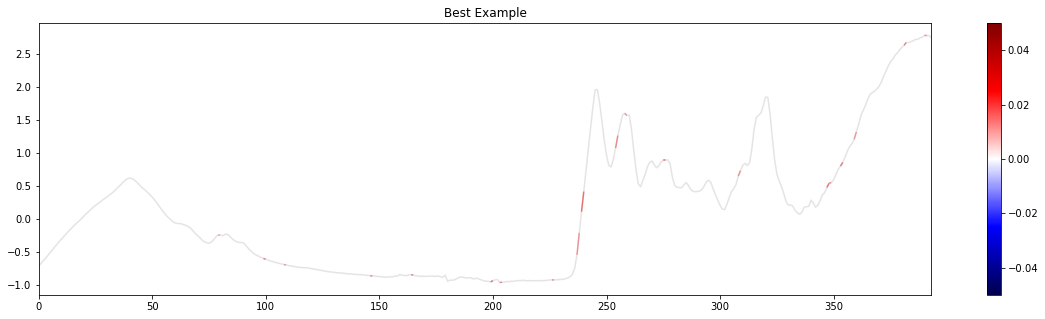

In [38]:
best = np.argmax(model.predict_proba(X_refined)[:,0])

ax = color_spectrum(
    x=np.arange(X_refined.shape[1]),
    y=X_refined[best,:], 
    importance_values=shap_values[0][best], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Best Example')

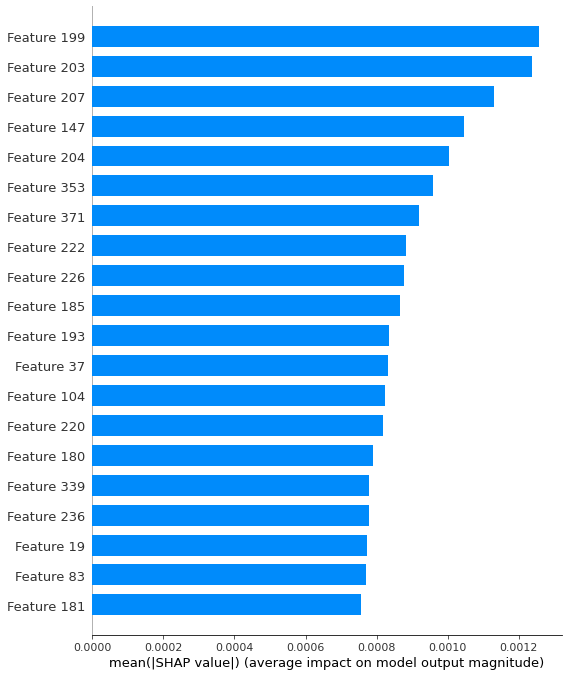

In [39]:
# You have to decide if this makes sense or not.
shap.summary_plot(
    shap_values=shap_values[0],
    features=X_refined,
    plot_type='bar'
)

In [40]:
# We can color an individual spectrum based on the features important to its own classification.
# This is useful to diagnose and individual prediction.
chosen = 0
bokeh_color_spectrum(x=np.arange(X_refined.shape[1]), 
                     y=X_refined[chosen, :], 
                     importance_values=shap_values[0][chosen])

In [41]:
# Or, we can color by the average SHAP importance.
# This is useful for visualizing how the model makes predictions on average.
chosen = 0
bokeh_color_spectrum(x=np.arange(X_refined.shape[1]), 
                     y=X_refined[chosen, :], 
                     importance_values=np.mean(np.abs(shap_values[0]), axis=0) # Mean ABSOLUTE value
                    )

# Analyze an EllipticManifold Model

In [42]:
import sklearn.manifold
from pychemauth.manifold.elliptic import EllipticManifold

In [43]:
mani = sklearn.manifold.Isomap
kwargs = {"n_neighbors":10, 
          "n_components":2, # Choose 2 for visualization
          "metric":'minkowski',
          "p":2, 
         }
model = EllipticManifold(0.05, mani, kwargs)

In [44]:
_ = model.fit(X_train, raw_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

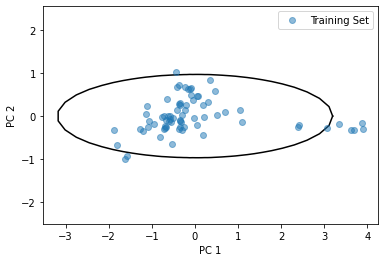

In [45]:
model.visualize([X_train], ["Training Set"])

In [46]:
explainer = shap.KernelExplainer(
    model = model.predict_proba, # Use probability function to "squash"
    data = shap.sample(X_train, 10, random_state=0), 
    seed = 42
)

In [47]:
shap_values = explainer.shap_values(X_train, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    ),
                                    gc_collect = True
                                   )

  0%|          | 0/72 [00:00<?, ?it/s]

In [48]:
explainer.expected_value

array([0.78680612, 0.21319388])

In [49]:
np.mean(model.predict_proba(X_train)[:,0]) 

0.7562381448575571

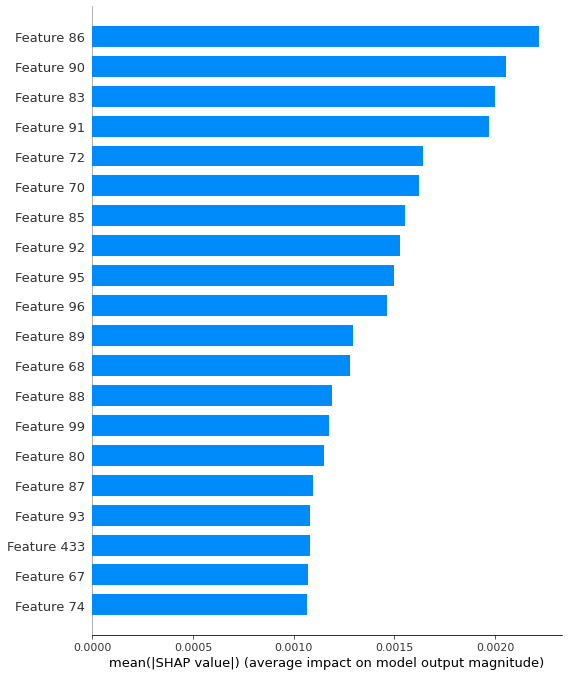

In [50]:
# On AVERAGE, it looks like the most important parts of the spectrum are somewhere around channel ~80
shap.summary_plot(
    shap_values=shap_values[0],
    features=X_train,
    plot_type='bar'
)

In [51]:
# Or, we can color by the average SHAP importance.
# This is useful for visualizing how the model makes predictions on average.
chosen = 0
bokeh_color_spectrum(x=np.arange(X_train.shape[1]), 
                     y=X_train[chosen, :], 
                     importance_values=np.mean(np.abs(shap_values[0]), axis=0) # Mean ABSOLUTE value
                    )

In [52]:
# This model seems to focus on characterizing the spectra based on a region of high variance.
chosen = 0
bokeh_color_spectrum(x=np.arange(X_train.shape[1]), 
                     y=X_train[chosen, :], 
                     importance_values=np.std(X_train, axis=0)**2 # Variance in the training data
                    )

# Analyze a PLS-DA Model

In [110]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/plsda3_train.csv'
else:
    loc = '../tests/data/plsda3_train.csv'
df = pd.read_csv(loc)

In [111]:
# now using SITE data
df.head()

,Group,Class,Name,Li,B,Na,Mg,Al,K,Ca,...,Eu,Gd,Dy,Ho,Er,Tm,Yb,Lu,Pb,U
0,1,JPN1,jpn_001,0.001287,0.435363,2.567587,143.601117,0.009235,818.961080,36.075419,...,1.318100e-04,0.000629,0.000041,0.000108,0.000385,0.000182,0.000295,0.000059,0.000182,0.000174
1,1,JPN1,jpn_002,0.001474,0.385210,4.595786,276.591018,0.084693,863.273852,50.704790,...,1.823270e-04,0.000592,0.000386,0.000051,0.000148,0.000021,0.000003,0.000023,0.000443,0.000723
2,1,JPN1,jpn_003,0.000748,0.289601,5.806715,117.037380,0.119564,851.174760,46.020288,...,7.401510e-07,0.000717,0.000353,0.000192,0.000434,0.000194,0.000054,0.000016,0.001359,0.000029
3,1,JPN1,jpn_004,0.000882,0.525801,0.554544,335.195531,0.388480,836.126629,45.437616,...,1.283760e-04,0.000481,0.000124,0.000041,0.000012,0.000180,0.000264,0.000029,0.000948,0.000236
4,1,JPN1,jpn_005,0.001387,0.659031,3.102831,213.051823,0.106865,756.238004,39.155470,...,1.014040e-04,0.000464,0.000608,0.000031,0.000178,0.000102,0.000050,0.000125,0.001060,0.000130


In [112]:
element_names = df.columns[3:]
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

In [113]:
from pychemauth.classifier.plsda import PLSDA

In [114]:
# Here the data are elemental levels so we will scale the X data
plsda = PLSDA(n_components=5, 
              alpha=0.05, 
              gamma=0.01, 
              not_assigned='UNKNOWN', 
              style="soft", 
              scale_x=True)

In [115]:
_ = plsda.fit(raw_x, raw_y)

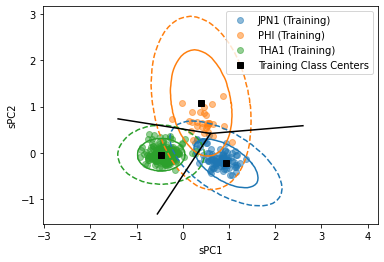

In [116]:
_ = plsda.visualize(styles=['hard', 'soft'])

In [118]:
plsda.predict(raw_x)[:10]

[['PHI'],
 ['JPN1', 'PHI'],
 ['PHI', 'JPN1'],
 ['JPN1', 'PHI'],
 ['JPN1', 'PHI'],
 ['PHI'],
 ['PHI'],
 ['PHI', 'JPN1'],
 ['PHI', 'JPN1'],
 ['PHI']]

In [123]:
plsda.categories

array(['JPN1', 'PHI', 'THA1'], dtype='<U4')

In [124]:
plsda.predict_proba(raw_x)[:10] # For soft model, probabilities are relative to each class and they do not sum to 1

array([[1.42629684e-01, 1.50467152e-01, 2.54058020e-03],
       [9.27816019e-01, 7.90137453e-02, 3.27855588e-08],
       [1.93948346e-01, 2.73806527e-01, 6.08853959e-05],
       [2.60981876e-01, 9.80216071e-02, 4.04783742e-03],
       [3.78702385e-01, 1.47117590e-01, 7.11024620e-04],
       [4.91961955e-02, 4.02095748e-01, 3.32079559e-07],
       [1.03415092e-01, 2.54870697e-01, 2.85835025e-04],
       [3.66653993e-01, 2.33323903e-01, 1.65167339e-05],
       [2.06206730e-01, 1.65227613e-01, 1.27035447e-03],
       [1.23939268e-01, 2.22995294e-01, 5.22296004e-04]])

In [128]:
# sorted(np.exp(-plsda.mahalanobis(raw_x)[:,-1]/2.), reverse=True)

In [135]:
# plsda.predict_proba predicts the probability for EACH individual class (in columns).
# Athough these do not sum to unity, we can still analyze each column individually with SHAP!
# The decision function can also be used which returns < 0 for outliers, and > 0 for inliers in a class - thus 0 is the class membership threshold which can be intutitive to analyze

explainer = shap.KernelExplainer(
    model = plsda.decision_function, 
    data = shap.sample(raw_x, 10, random_state=0), # vs. data = raw_x to use full training set
    seed = 42
)

In [ ]:
shap_values = explainer.shap_values(raw_x, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [raw_x.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    ),
                                    gc_collect = True
                                   )

  0%|          | 0/345 [00:00<?, ?it/s]

In [ ]:
len(shap_values) # There is a set of shap values for each class

In [132]:
explainer.expected_value # Average for each class in the training set (columnwise)

array([0.28006851, 0.1073146 , 2.13022355])

In [ ]:
np.mean(plsda.decision_function(raw_x), axis=0)

## Examine Categories

In [67]:
chosen_class = 2 # Which category? 0, 1, or 2

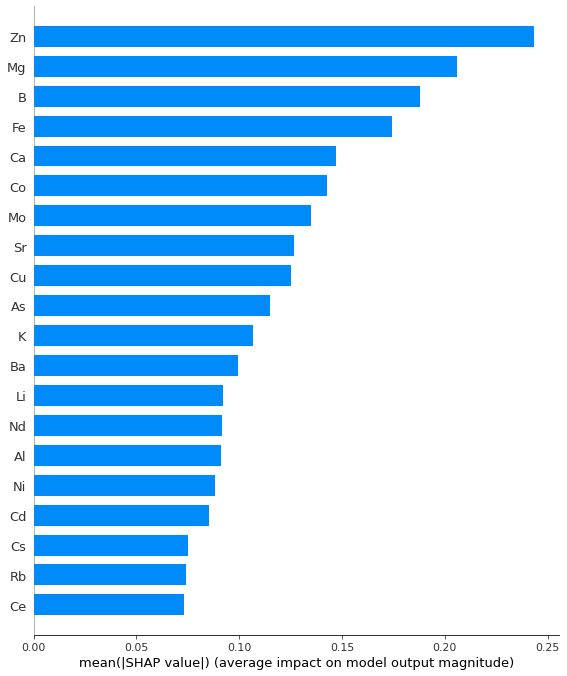

In [68]:
sv = shap_values[chosen_class]
plsda.categories[chosen_class]

shap.summary_plot(
    shap_values=sv,
    features=raw_x,
    feature_names=element_names,
    plot_type='bar'
)

In [69]:
# You can see that the SHAP values add up to the probability a point is an inlier in a class:

examine_pt = 12

shap_sum = np.sum(shap_values[chosen_class][examine_pt]) + explainer.expected_value[chosen_class]
pred_prob = plsda.predict_proba(raw_x)[examine_pt][chosen_class]

print(shap_sum, pred_prob, shap_sum-pred_prob)

6.490217439036883e-07 6.49021744778142e-07 -8.74453733097527e-16


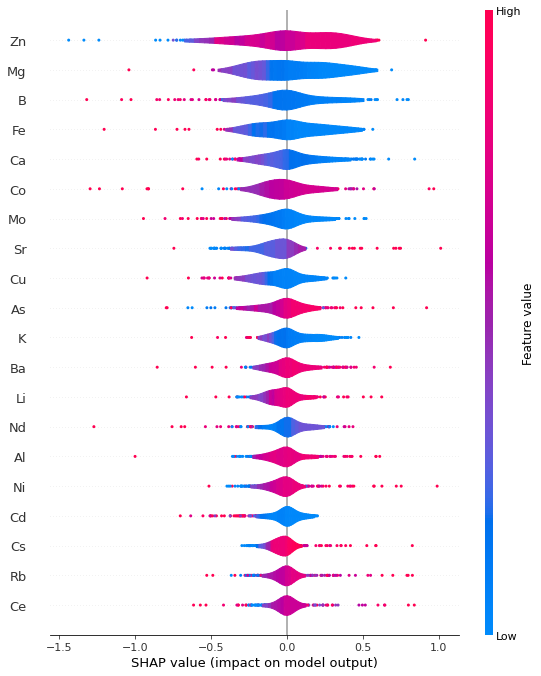

In [70]:
shap.summary_plot(
    shap_values=sv,
    features=raw_x,
    feature_names=element_names,
    plot_type='violin'
)

In [71]:
shap.force_plot(
    base_value=explainer.expected_value[chosen_class],
    shap_values=sv, 
    features=raw_x,
    feature_names=element_names
)

In [72]:
# Look at the lowest probability example
look_at = np.argmin(plsda.predict_proba(raw_x)[:,chosen_class]) 

shap.force_plot(
    base_value=explainer.expected_value[chosen_class], 
    shap_values=sv[look_at,:], 
    features=raw_x[look_at,:], 
    feature_names=element_names
)

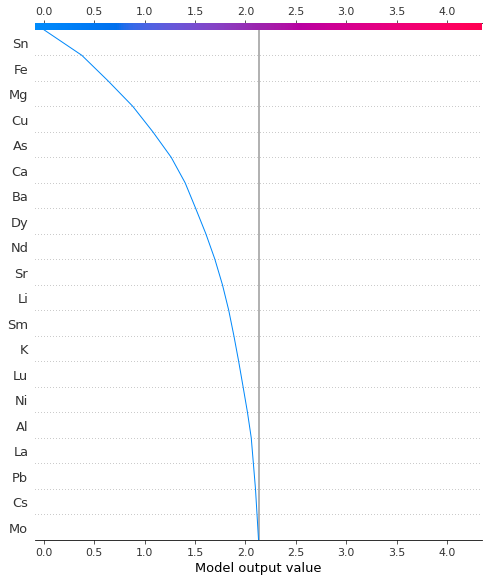

In [73]:
shap.decision_plot(
    explainer.expected_value[chosen_class], 
    sv[look_at,:],
    feature_names=element_names.tolist()
)

In [74]:
# Look at the highest probability example
look_at = np.argmax(plsda.predict_proba(raw_x)[:,chosen_class]) 

shap.force_plot(
    base_value=explainer.expected_value[chosen_class], 
    shap_values=sv[look_at,:], 
    features=raw_x[look_at,:], 
    feature_names=element_names
)

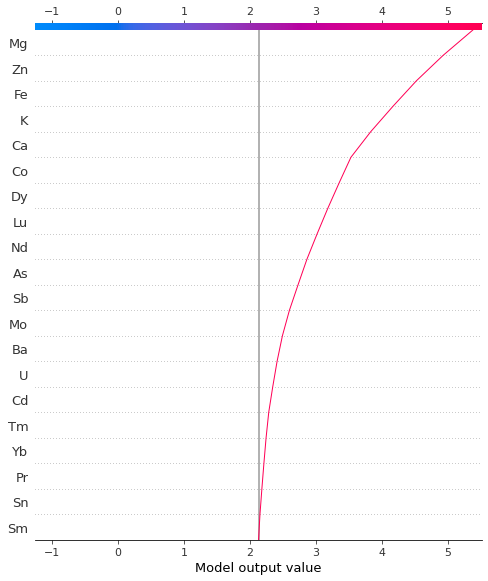

In [75]:
shap.decision_plot(
    explainer.expected_value[chosen_class], 
    sv[look_at,:],
    feature_names=element_names.tolist()
)

## How are decisions made?

In [76]:
# Let's assess the specificity of the model - we can look at examples of when a sample is predicted to belong
# to a class that it does not.

In [77]:
chosen_class = 0
sv = shap_values[chosen_class]
print('Examining model for : {}'.format(plsda.categories[chosen_class])) # Let's look at samples which belong to this category

Examining model for : JPN1


These samples belong to : PHI


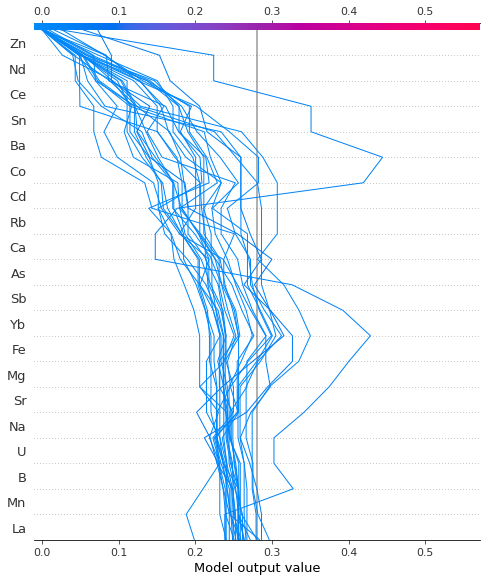

In [78]:
compare_class = (chosen_class+1)%3 # Let's see how the model predicts for other classes
print('These samples belong to : {}'.format(plsda.categories[compare_class]))

# Look at samples that belong to compare_class
mask = raw_y == plsda.categories[compare_class]

# These should NOT be predicted to belong to chosen_class
wrong = plsda.predict_proba(raw_x[mask])[:,chosen_class] > 0.5

shap.decision_plot(
    explainer.expected_value[chosen_class], 
    sv[mask,:], 
    feature_names=element_names.tolist(),
    highlight=wrong
)

In [79]:
# None are wrong here, and the model is very certain (low prob << 50%) which is a good sign.

These samples belong to : THA1


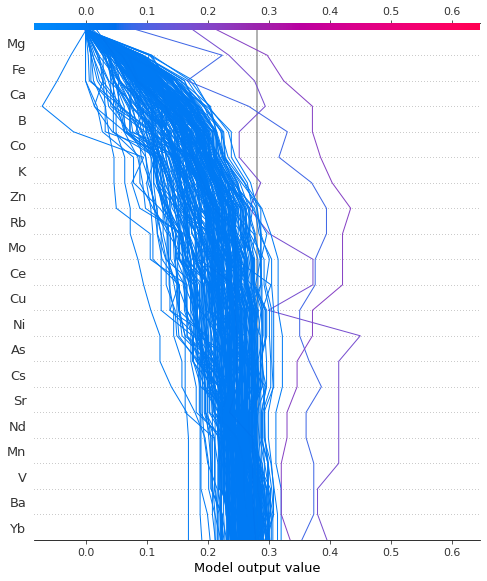

In [80]:
compare_class = (chosen_class+2)%3 # Let's see how the model predicts for other classes
print('These samples belong to : {}'.format(plsda.categories[compare_class]))

# Look at samples that belong to compare_class
mask = raw_y == plsda.categories[compare_class]

# These should NOT be predicted to belong to chosen_class
wrong = plsda.predict_proba(raw_x[mask])[:,chosen_class] > 0.5

shap.decision_plot(
    explainer.expected_value[chosen_class], 
    sv[mask,:], 
    feature_names=element_names.tolist(),
    highlight=wrong
)

In [81]:
# These ones that are wrong seem like outliers, whereas most are predicted correctly, confidently

In [108]:
# # However, in the latent space, these wrong ones appear to be just "on the edge" and could be included
# # if alpha (type 1 error rate) was adjusted.  That is not the point - we WANT a few of those on the edge
# # to be excluded to draw the boundary, so this appears to be reasonable.
# t = plsda.transform(raw_x[mask][~wrong])
# plt.plot(t[:,0], t[:,1], 'o')

# t = plsda.transform(raw_x[mask][wrong])
# plt.plot(t[:,0], t[:,1], 'o')

In [ ]:
# # First incorrect point
# shap.force_plot(
#     base_value=explainer.expected_value[chosen_class], 
#     shap_values=sv[mask][wrong,:][0], 
#     features=raw_x[mask][wrong,:][0], 
#     feature_names=element_names
# )

In [ ]:
# # Second incorrect point
# shap.force_plot(
#     base_value=explainer.expected_value[chosen_class], 
#     shap_values=sv[mask][wrong,:][1], 
#     features=raw_x[mask][wrong,:][1], 
#     feature_names=element_names
# )

These samples belong to : JPN1


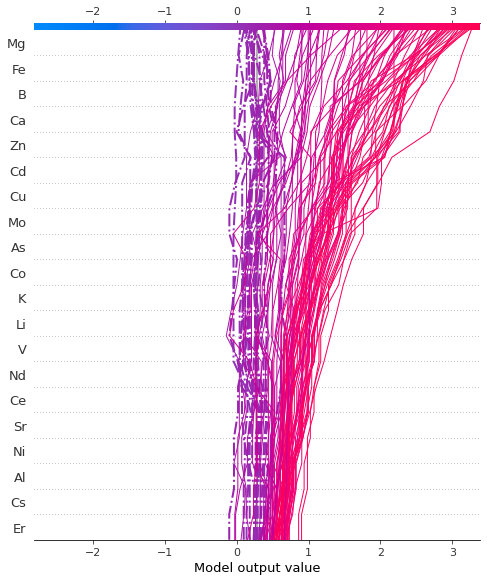

In [109]:
compare_class = chosen_class # Let's see how the model predicts for other classes
print('These samples belong to : {}'.format(plsda.categories[compare_class]))

# Look at samples that belong to compare_class
mask = raw_y == plsda.categories[compare_class]

# These SHOULD be predicted to belong to chosen_class
wrong = plsda.predict_proba(raw_x[mask])[:,chosen_class] < 0.5

shap.decision_plot(
    explainer.expected_value[chosen_class], 
    sv[mask,:], 
    feature_names=element_names.tolist(),
    highlight=wrong
)

In [ ]:
# Although a few are wrong, they are pretty close to the "pack"